# IS53051A Machine Learning Assignment
### Jake Tyler (33683668) & Sonny Holland (33648903)

# Setting up our notebook


Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

Importing the dataset

In [2]:
dataset = pd.read_csv('datcw_na.csv')

# Data inspection and visualisation

First we take a brief look at our dataset.

In [3]:
print(dataset.head(), "\n")
print(dataset.info())

   X0    X1      X2      X3      X4    X5    X6   X7   X8      Y
0  C3  1.19  622.55     NaN   89.31  7.00  1.98  0.0  0.0  15.55
1  C1  1.19  622.55  323.40  109.15  7.70  3.00  0.0  0.0  15.55
2  C1  0.88  463.05  291.06   99.23  5.67  4.40  0.0  0.0  15.55
3  C2  0.79  509.36  291.06  121.28  6.30  4.05  0.0  0.0  15.55
4  C1  0.89  507.15  385.39  121.28  7.70  2.00  0.0  0.0  20.84 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      768 non-null    object 
 1   X1      768 non-null    float64
 2   X2      768 non-null    float64
 3   X3      728 non-null    float64
 4   X4      768 non-null    float64
 5   X5      768 non-null    float64
 6   X6      768 non-null    float64
 7   X7      768 non-null    float64
 8   X8      768 non-null    float64
 9   Y       768 non-null    float64
dtypes: float64(9), object(1)
memory usage: 60.1+ KB
None


### Understanding our target variable

Keeping in mind that this is a regression problem, we will likely use the root mean squared error (RMSE) loss function to evaluate our model. The goal is to minimise the difference between the predicted and actual values. To achieve this, it is crucial to understand our target variable, as the values will show how far off our predictions are from the actual values, in units relevant to the dataset feature. Unfortunately, the dataset does not provide any information on the units of the target variable. We must make an informed assumption by examining the column.

Considering that we are dealing with a heating load, we can deduce that the target variable represents the amount of energy required for each sample (home) to maintain a comfortable temperature. Knowing this context helps us assess the performance of our model more accurately.

In [4]:
print(dataset['Y'].describe())

count    768.000000
mean      22.307201
std       10.090196
min        6.010000
25%       12.992500
50%       18.950000
75%       31.667500
max       43.100000
Name: Y, dtype: float64


Seeing that we are looking at a range of numbers from 22.307 to 43.1, we can make more informed conclusions when looking at loss metrics - and doing some informal research. It is likely the unit in question is either kWh (kilowatt-hours) or BTUs (British Thermal Units), as these are most typically used in such research, reverse searching the dataset provided for this assignment online, it can be found the dataset was created amidst a study conducted at Oxford University, knowing this is a UK based study, it is more likely that kWh is the metric used here; assuming off the understanding europe typically uses metric measurements, whilst america uses imperial measurements.

https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

### X3 has missing values and X0 is non-numerical

Here we can verify that column X3 contains 768 entries, where 40 values from those entries are missing.

We can also confirm that the column X0 is a categorical variable.

In [5]:
print(f"X3 number of entries: {dataset['X3'].size}")
print(f"X3 missing values: {dataset['X3'].isna().sum()}")
print(f"X0 contains: {dataset['X0'].unique()}")


X3 number of entries: 768
X3 missing values: 40
X0 contains: ['C3' 'C1' 'C2']


### Assessing options for handling categorical data and missing values in our dataset

When dealing with categorical data, we can either drop the column entirely or use one-hot encoding. One-hot encoding is the preferred method in our case, later in this analysis we can see this feature of the dataset does not have a neglegible correlation on the target variable. One-hot encoding allows us to make 3 new featrues from the categorical variable X0. These are all binary variables, where 1 represents the presence of the feature and 0 represents the absence of the feature.

For handling missing values, if the number of missing values is small and randomly distributed throughout the dataset we can consider replacing them with the mean, median, or mode of the non-missing values. Although, if the missing values are large in number or not randomly distributed it may be better to drop the the column altogether.

To better understand the missing values in our dataset, we can perform some basic types of analysis.

### Checking the percentage of missing data

We can check the percentage of missing values in our colums. Typically, if the percentage less than 5% we can consider this a small amount.

In [6]:
print(f"percentage of missing values per column:\n{dataset.isna().sum() / dataset.shape[0]}")

percentage of missing values per column:
X0    0.000000
X1    0.000000
X2    0.000000
X3    0.052083
X4    0.000000
X5    0.000000
X6    0.000000
X7    0.000000
X8    0.000000
Y     0.000000
dtype: float64


We can see the percentage of missing values is 0 amongst all but one feature. Whilst X3 (the outlying feature) does have 5% of its data missing, this is a small amount of missing data, one where imputation of the mean, mode, or median could infact be a viable option.

It's also important to note that the missing data (left alone) may still have an impact on the analysis. To continue, we can conduct a visual inspection to check the distribution and conclude whether it is random or non-random.

### Checking the distribution of values in X3

Using a histogram, we can visualise the distribution of non-missing values which will help us gain insight into the distribution of missing values.

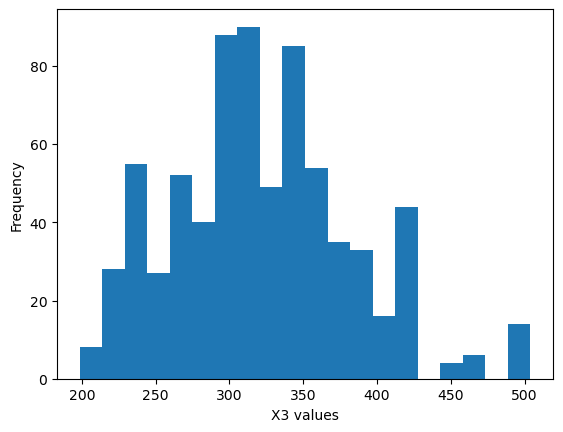

In [7]:
plt.hist(dataset['X3'], bins=20)
plt.xlabel('X3 values')
plt.ylabel('Frequency')
plt.show()

From this, we can verify that the missing values in X3 follow typical random distribution patterns.

Since the percentage of missing values is also relatively small, we can consider replacing them with an appropriate imputation method such as the mean, mode or median.

Before deciding on an imputation method, it is important to analyse the relationship between X3 and the target variable. It is also important to test different imputation methods and examine their impact on the correlations with the target variable.

### Examining correlations between X3 and the target variable Y

array([[<AxesSubplot: xlabel='Y', ylabel='Y'>,
        <AxesSubplot: xlabel='X3', ylabel='Y'>],
       [<AxesSubplot: xlabel='Y', ylabel='X3'>,
        <AxesSubplot: xlabel='X3', ylabel='X3'>]], dtype=object)

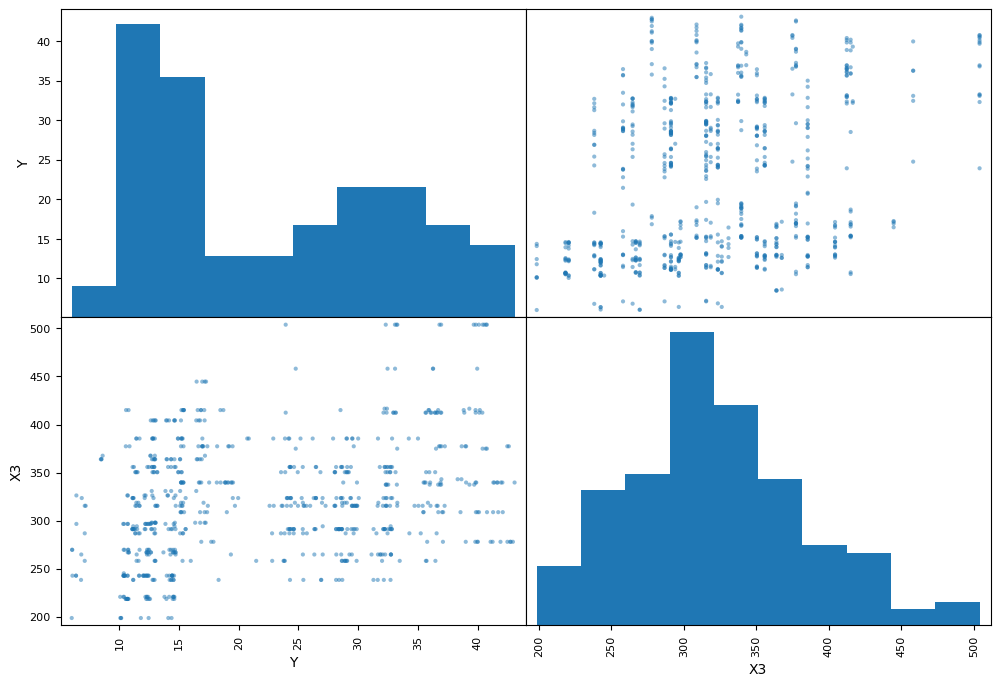

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["Y", "X3"]
scatter_matrix(dataset[attributes], figsize=(12, 8))

From this inspection, it would be reasonable to assume that there is a weak positive linear relationship between X3 and the target variable. This means that as the value of X3 increases, the value of the target variable also tends to increase, but the relationship is not very strong or consistent.

### Testing different imputation methods and examining correlations

Here we calculate the correlations between X3 and Y with the mean, mode, and median imputations.

Its worth mentioning that there was a consideration to simulate missingness in our imputation methods. However, this is typically only needed when there is a large amount of missing data or if the missing data is not randomly distributed so the decision was made to leave this out.

In [10]:
corr_mean = dataset['X3'].fillna(dataset['X3'].mean()).corr(dataset['Y'])
corr_mode = dataset['X3'].fillna(dataset['X3'].mode()[0]).corr(dataset['Y'])
corr_median = dataset['X3'].fillna(dataset['X3'].median()).corr(dataset['Y'])

corr_dict = {
    'mean': corr_mean,
    'mode': corr_mode,
    'median': corr_median,
}

best_imputation = max(corr_dict, key=corr_dict.get)

print(f"Correlation between X3 and Y (mean imputation): {corr_mean}")
print(f"Correlation between X3 and Y (mode imputation): {corr_mode}")
print(f"Correlation between X3 and Y (median imputation): {corr_median}", "\n")
print(f"Best imputation method for X3: {best_imputation}")
print(
    f"Best imputation method's correlation with Y: {corr_dict[best_imputation]}")


Correlation between X3 and Y (mean imputation): 0.30511448543332886
Correlation between X3 and Y (mode imputation): 0.30796491944608173
Correlation between X3 and Y (median imputation): 0.3059704038634418 

Best imputation method for X3: mode
Best imputation method's correlation with Y: 0.30796491944608173


Our results suggest that the best imputation method would be to replace the missing values in our column with the mode of the non-missing values.

They also suggest that the above imputing methods overall have a small positive impact on the correlation between X3 and Y, confirming that there is a weak positive linear relationship between the two variables, and that the choice of imputation method may not even have much of an impact on the analysis altogether.

For the purpose of this exercise, we have decided to proceed with the mode imputation method. In other cases it may be worth exploring other means of imputation, such as regression imputation or multiple imputation, to see if they produce more robust results. Alternatively, we could also consider using analysis methods that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.

As an afterthought, it was discovered that using mode imputation is typically used for categorical data. We discussed taking this out but came to the conclusion that since the imputation methods overall have such a small positive impact on the analysis, we decided to leave it in as it still showed the best correlations.

# Data preprocessing

First we create a correlation matrix to gain insights into how much each feature is related to our target variable overall. After this, we will then make a decision on which features are important and which ones are not, and will drop the less important ones accordingly.

In [11]:
corr_matrix = dataset.corr()
corr_matrix["Y"].sort_values(ascending=False)

/var/folders/4t/8hjy6t1s4v9_4wgdjp2xb_m00000gn/T/ipykernel_3327/609732122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Y     1.000000
X5    0.815769
X1    0.454177
X3    0.312449
X7    0.255901
X8    0.087106
X6    0.001340
X2   -0.481192
X4   -0.771040
Name: Y, dtype: float64

### Checking other correlations and some decisions on feature selection 

We can examine correlations between other features in our dataset to understand their relationships. In our case, we have set a correlation threshold, but it's still worth investigating the associations between other features in the dataset as some features may indirectly affect the target variable through their correlations with each other.

By examining these relationships, we can make informed decisions on which features to keep, even if they fall below the correlation threshold.

In [12]:
threshold = 0.7
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr.append((colname, colname2, corr_matrix.iloc[i, j]))

for pair in high_corr:
    print(f"Strong correlation between: {pair}")


Strong correlation between: ('X5', 'X4', -0.8130080270394002)
Strong correlation between: ('Y', 'X4', -0.7710402825450126)
Strong correlation between: ('Y', 'X5', 0.8157693512264856)


We can see from these results that both X4 and X5 have strong negative correlations with each other, and X5 has a strong positive correlation with the target variable while X4 has a strong negative correlation with Y. This suggests that both X4 and X5 may be important predictors of Y and dropping either one of them could result in losing important information.

### Feature selection

In this step, we create a modified copy of our dataset that includes feature selection. We define a function that calculates the absolute value of the correlation between features, and if the correlation value falls below a certain threshold we then remove the corresponding column from the dataset.

In [13]:
dataset_fs = dataset.copy()


def drop_correlation_columns(data, threshold):
    features_to_drop = list(
        dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)
    print(f"Dropping the following labels: {features_to_drop}")
    data.drop(features_to_drop, axis=1, inplace=True)
    return data


dataset_fs = drop_correlation_columns(dataset_fs, 0.25)

print(f"original dataset: {dataset.shape}")
print(f"feature selection copy: {dataset_fs.shape}")


Dropping the following labels: ['X6', 'X8']
original dataset: (768, 10)
feature selection copy: (768, 8)


/var/folders/4t/8hjy6t1s4v9_4wgdjp2xb_m00000gn/T/ipykernel_3327/4145326516.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)


### One-hot encoding (according to our previous conclusions)

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

encoder = OneHotEncoder(sparse_output=False)
encoder_fs = OneHotEncoder(sparse_output=False)

onehot_X0 = encoder.fit_transform(dataset['X0'].values.reshape(-1, 1))
onehot_X0_fs = encoder_fs.fit_transform(dataset_fs['X0'].values.reshape(-1, 1))

dataset = dataset.drop('X0', axis=1)
dataset_fs = dataset_fs.drop('X0', axis=1)

dataset = pd.concat([dataset, pd.DataFrame(onehot_X0)], axis=1)
dataset_fs = pd.concat([dataset_fs, pd.DataFrame(onehot_X0_fs)], axis=1)


### Data imputation method (according to our previous conclusions)

In [15]:
mode_X3 = dataset['X3'].mode()[0]
mode_X3_fs = dataset_fs['X3'].mode()[0]

dataset['X3'].fillna(mode_X3, inplace=True)
dataset_fs['X3'].fillna(mode_X3_fs, inplace=True)

print(f"X3 missing values: {dataset['X3'].isna().sum()}")

X3 missing values: 0


### Train test split

Here, we split the dataset into training and testing sets. Note that we have selected X5 (the 'OverallHeight' feature) as our target variable because it has the highest correlation with the target variable. We stratify the dataset based on this feature to ensure that the training and testing sets have similar distributions of this important variable.


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.3, random_state=42)

# convert X to a pandas dataframe so we can use the loc function
for train_index, test_index in stratified_split.split(dataset, dataset['X5']):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]

for train_index, test_index in stratified_split.split(dataset_fs, dataset_fs['X5']):
    train_set_fs = dataset_fs.loc[train_index]
    test_set_fs = dataset_fs.loc[test_index]

print(dataset_fs.columns)
print(train_set_fs.columns)


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')


### Standard scaler

We perform feature scaling on the training and test sets to ensure that the features are on the same scale and have similar ranges of values.

This is important because many machine learning models assume that all features are normalised to a similar scale. If features are not on a similar scale, some features with larger values can dominate the model, while others with smaller values may be ignored.

In [17]:
# scale the features
train_set.columns = train_set.columns.astype(str)
test_set.columns = test_set.columns.astype(str)

train_set_fs.columns = train_set_fs.columns.astype(str)
test_set_fs.columns = test_set_fs.columns.astype(str)

train_scaler = StandardScaler()
test_scaler = StandardScaler()

train_scaler_fs = StandardScaler()
test_scaler_fs = StandardScaler()

train_set = train_scaler.fit_transform(train_set)
test_set = test_scaler.fit_transform(test_set)

train_set_fs = train_scaler_fs.fit_transform(train_set_fs)
test_set_fs = test_scaler_fs.fit_transform(test_set_fs)

print(train_set.shape)
print(test_set.shape)

print(train_set_fs.shape)
print(test_set_fs.shape)

(537, 12)
(231, 12)
(537, 10)
(231, 10)


### Split X and Y

We split the dataset into separate input features (X) and output variable (Y), allowing us to use the input features for making predictions about the target variable.

In [18]:
X_train = np.delete(train_set, 9, axis=1)
y_train = train_set[:, 9]
X_test = np.delete(test_set, 9, axis=1)
y_test = test_set[:, 9]

X_train_fs = np.delete(train_set_fs, 9, axis=1)
y_train_fs = train_set_fs[:, 9]
X_test_fs = np.delete(test_set_fs, 9, axis=1)
y_test_fs = test_set_fs[:, 9]


# Instantiating our models

### creating a polynomial regression model with regularisation

The Scikit-learn API provides the GridSearchCV class for evaluating and fine-tuning multiple models and pipelines. Most models needed for our analysis are already available in the API, making it easier to select the best one.

However, the polynomial regression model is not included, so we create it using Scikit-learn's pipeline API. By defining PolynomialRegression as a subclass of BaseEstimator and RegressorMixin from sklearn.base, we ensure its compatibility with our modular approach. This allows us to use PolynomialRegression as an estimator within the Scikit-learn ecosystem and fine-tune its hyperparameters using GridSearchCV, just like the other models.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures


class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2, alpha=0.01, solver='auto',
                 max_iter=10, tol=1e-3):
        self.degree = degree
        self.alpha = alpha
        self.solver = solver
        self.max_iter = max_iter
        self.tol = tol
        self.model = Pipeline([
            ('poly', PolynomialFeatures(degree=self.degree)),
            ('ridge', Ridge(alpha=self.alpha, solver=self.solver,
                            max_iter=self.max_iter, tol=self.tol))
        ])

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def set_params(self, **params):
        for param, value in params.items():
            if param.startswith('poly__'):
                setattr(self.model.named_steps['poly'],
                        param[len('poly__'):], value)
            elif param.startswith('ridge__'):
                setattr(self.model.named_steps['ridge'],
                        param[len('ridge__'):], value)
        return self
    def get_params(self, deep=True):
        params = {
            'degree': self.degree,
                'alpha': self.alpha,
                'solver': self.solver,
                'max_iter': self.max_iter,
                'tol': self.tol,
            }
        if deep:
                params.update({
                    'poly__' + key: value
                    for key, value in self.model.named_steps['poly'].get_params().items()
                })
                params.update({
                    'ridge__' + key: value
                    for key, value in self.model.named_steps['ridge'].get_params().items()
                })
        return params


### Instantiating all other models

Here, we define a dictionary of models and a dictionary of hyperparameters to be tuned for each model using the Scikit-learn GridSearchCV class.

The models dictionary contains instances of the following regression models: LinearRegression, Ridge, Lasso, ElasticNet, and PolynomialRegression. Each key in the dictionary corresponds to the name of the regression model.

The param_grid dictionary specifies a set of hyperparameters to be searched over for each model using GridSearchCV. The keys of the param_grid dictionary match the keys in the models dictionary.

For example, for the Ridge model, the param_grid dictionary contains a list of candidate values for the hyperparameters 'alpha' and 'solver'. For the PolynomialRegression model, the param_grid dictionary includes the degree of the polynomial features to be generated, the hyperparameters of the Ridge regression model that will be used for regularisation, and additional hyperparameters such as whether to normalise the data.

In [20]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'PolynomialRegression': PolynomialRegression()
}

param_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'max_iter': [10, 100, 1000, 5000, 10000],
              'tol': [1e-3, 1e-4, 1e-5]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                   'l1_ratio': [0.1, 0.5, 0.9, 1.0],
                   'max_iter': [10, 100, 1000, 5000, 10000],
                   'tol': [1e-3, 1e-4, 1e-5]},
    'PolynomialRegression': {'poly__degree': [2, 3, 4, 5],
                             'ridge__alpha': [0.01, 0.5, 1.0],
                             'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sag'],
                             'ridge__normalize': [True, False],
                             'ridge__max_iter': [10, 100],
                             'ridge__tol': [1e-3, 1e-4, 1e-5], }
}


### Perform grid search and save results


In [21]:
print(X_train.shape)
print(X_train_fs.shape)

(537, 11)
(537, 9)


In [22]:
from sklearn.model_selection import GridSearchCV

trained_models = {}
param_results = {}
results = []

for model_name, model in models.items():
    params = param_grid[model_name]
    grid_search = GridSearchCV(
        model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search_fs = GridSearchCV(
        model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_fs.fit(X_train_fs, y_train_fs)
    trained_models[model_name] = grid_search.best_estimator_
    trained_models[model_name + '_fs'] = grid_search_fs.best_estimator_
    param_results[model_name] = grid_search.best_params_
    param_results[model_name + '_fs'] = grid_search_fs.best_params_
    results.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
    })
    results.append({
        'model': model_name + '_fs',
        'best_score': grid_search_fs.best_score_,
        'best_params': grid_search_fs.best_params_
    })


/usr/local/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e-02, tolerance: 4.185e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.563e-01, tolerance: 4.283e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

In [23]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['best_score'], ascending=False)
results_df

,model,best_score,best_params
1,LinearRegression_fs,-6.359513e-31,{}
0,LinearRegression,-1.463868e-30,{}
9,PolynomialRegression_fs,-4.999904e-10,"{'poly__degree': 2, 'ridge__alpha': 0.01, 'rid..."
8,PolynomialRegression,-6.984350e-10,"{'poly__degree': 2, 'ridge__alpha': 0.01, 'rid..."
3,Ridge_fs,-2.310368e-09,"{'alpha': 0.01, 'solver': 'auto'}"
2,Ridge,-2.437699e-09,"{'alpha': 0.01, 'solver': 'lsqr'}"
7,ElasticNet_fs,-3.942558e-04,"{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1..."
5,Lasso_fs,-4.044193e-04,"{'alpha': 0.01, 'max_iter': 100, 'tol': 1e-05}"
6,ElasticNet,-4.179907e-04,"{'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1..."
4,Lasso,-4.212314e-04,"{'alpha': 0.01, 'max_iter': 100, 'tol': 1e-05}"


### Evaluate on the two best models

In [24]:
from sklearn.metrics import mean_squared_error

best_linearreg = trained_models['LinearRegression'].set_params(
    **param_results['LinearRegression'])
y_pred = best_linearreg.predict(X_test)
linreg_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root mean squared error: {linreg_rmse}")


Root mean squared error: 0.02317149380233864


In [25]:
best_polynomialregression_fs = trained_models['PolynomialRegression_fs'].set_params(
    **param_results['PolynomialRegression_fs'])
y_pred = best_polynomialregression_fs.predict(X_test_fs)
polyreg_rmse = mean_squared_error(y_test_fs, y_pred, squared=False)
print(f"Root mean squared error: {polyreg_rmse}")


Root mean squared error: 0.07408518576797428


Now, to make these scores more ledgable we will calculate the percentage of the RMSE compared to the actual range of values in the target variable.

In [26]:
data_range = np.max(y_test) - np.min(y_test)
linreg_rmse_percentage = (linreg_rmse / data_range) * 100
polyreg_rmse_percentage = (polyreg_rmse / data_range) * 100

print(f"Linear Regression RMSE: {linreg_rmse_percentage:.2f}%")
print(f"Polynomial Regression RMSE: {polyreg_rmse_percentage:.2f}%")

Linear Regression RMSE: 1.06%
Polynomial Regression RMSE: 3.40%


The first best model is a simple linear regression model, with no regularisation applied. The second best is a polynomial regression model, using a ridge estimator to make use of l2 regularization.
 
The Root mean squared error (RMSE) is a metric used for evaluating regression models. Its calculated by taking the square root of the mean squared error (MSE), which is the average squared difference between the predicted values and actual values. The lower the RMSE, the better the model is at making predictions.

Here we can see both models are performing relatively well.

In this case, the rmse of the linear regression model is 0.0231, assuming we are working in kWh, this means that the model is predicting the energy consumption of a building within 1.06% of the actual value. Our second best performing model, the polynomial regression model making use of a feature selected dataset, achieves a rmse of 0.0740, meaning our model is predicting within 3.40% of the actual value.

Overall, both models have low RMSE values, which suggests that they are performing well on the test set. However, these scores feel a little too good to be true, so we should be cautious about overfitting - to be sure, we plot the learning curves for both models to see if overfitting is happening.

### Plot our learning curves

In [27]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, X_train, Y_train, title, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, Y_train, cv=5, scoring=make_scorer(mean_squared_error, squared=False), n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, 'o-',
            color='r', label='Training error')
    ax.plot(train_sizes, test_scores_mean, 'o-',
            color='g', label='Cross-validation error')

    ax.set_title(title)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Root Mean Squared Error')
    ax.legend(loc='best')


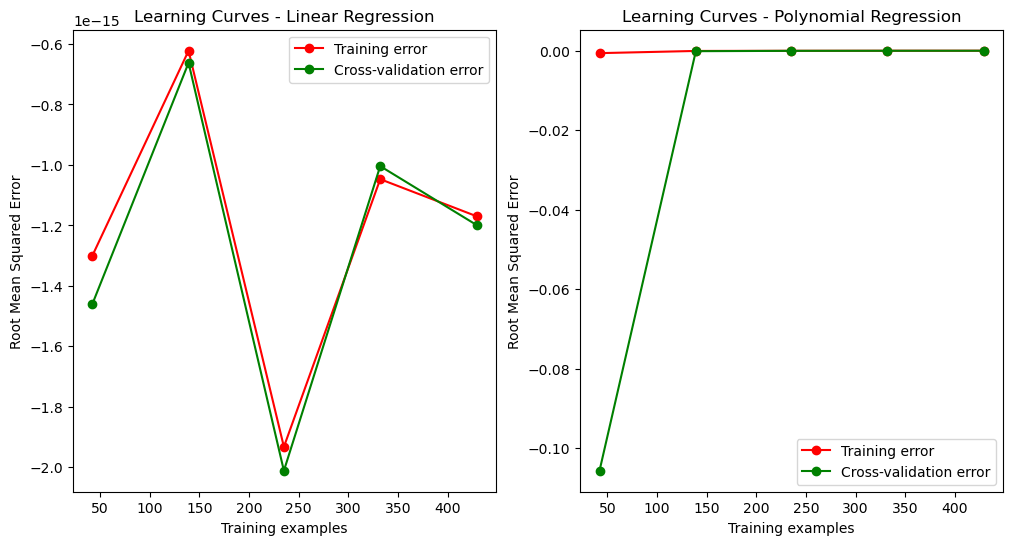

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
linear_regression = LinearRegression()
polynomial_regression = PolynomialRegression().set_params(
    **param_results['PolynomialRegression_fs'])
plot_learning_curves(linear_regression, X_train, y_train,
                     'Learning Curves - Linear Regression', axs[0])
plot_learning_curves(polynomial_regression, X_train_fs, y_train_fs,
                     'Learning Curves - Polynomial Regression', axs[1])
plt.show()


We see here that both models display unconventional training behavior. The linear regression model appears to overfit, following an erratic learning trajectory. This overfitting may be due to the model's simplicity, lack of regularisation, or feature selection when applied to our small dataset. As a consequence, we will not proceed with this model.

The polynomial regression model fits quite rapidly, reaching a low RMSE and stabilizing at that value. It doesn't seem to overfit, and when performing cross-validation (beneficial for smaller datasets), a more gradual curve emerges. The model is likely sophisticated for what is essentially a simpler problem.

Given these observations, we will not choose the linear regression model for this task. Instead, we'll proceed with the third-best model identified in our original iterative grid search.

### Evalute now, third best model and plot learning curve

In [29]:
best_ridge_fs = trained_models['Ridge_fs'].set_params(
    **param_results['Ridge_fs'])
y_pred = best_ridge_fs.predict(X_test_fs)
ridge_rmse = mean_squared_error(y_test_fs, y_pred, squared=False)
print(f"Root mean squared error: {ridge_rmse}")

Root mean squared error: 0.02291636294478785


In [30]:
data_range = np.max(y_test_fs) - np.min(y_test_fs)
ridge_rmse_percentage = (ridge_rmse / data_range) * 100
print(f"Ridge Regression RMSE: {ridge_rmse_percentage:.2f}%")

Ridge Regression RMSE: 1.09%


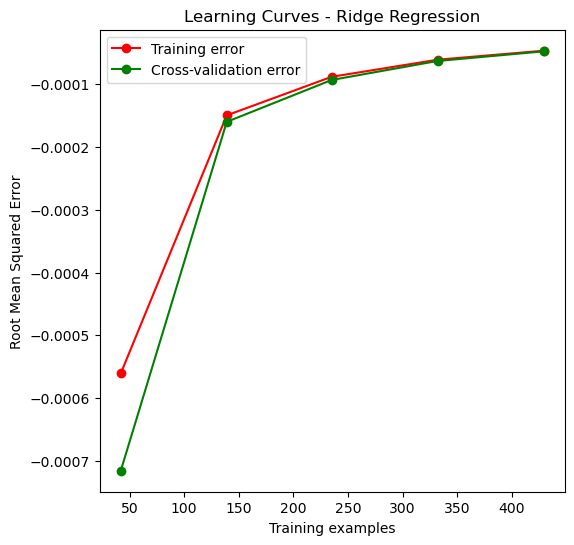

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ridge = Ridge().set_params(**param_results['Ridge_fs'])
plot_learning_curves(ridge, X_train_fs, y_train_fs, 'Learning Curves - Ridge Regression', ax)
plt.show()

Surprisingly, we can see that the Ridge Regression model is achieving a lower RMSE score compared to the Polynomial Regression model, while avoiding overfitting. The model exhibits a stable learning trajectory and a remarkably low RMSE score, resulting in predictions that are only 1.09% off the actual value.

# Summary and conclusion

During the data preprocessing phase, we applied one-hot encoding and imputed missing values with the mode. This is typically an unusual choice for regression; however, after exploring feature correlations and comparing different means of imputation, we found it to be the most effective.

We used a standard scaler on our data and partitioned the dataset into training and testing sets with a stratified shuffle split. This was done to account for the small dataset size (around 750 samples). We stratified based on the 'X5' (Overall Height) feature, as it had the strongest correlation to our target variable. This ensured that the dataset split was representative of the 'X5' distribution, which is crucial when working with small datasets to avoid introducing bias into the model. A duplicate of our dataset was created to experiment with feature selection, which improved performance across all models. Features with a correlation of less than 0.25 (out of 1.0) to the target variable were dropped; in this case, 'X6' and 'X8' were removed.

We trialed several models: Linear Regression, Polynomial Regression with L2 regularization (provided by Ridge estimator), Elastic Net, Lasso, and Ridge Regression. Grid searches were performed iteratively on all models and the 'feature-selected' dataset. A variety of parameters were tested for each model to identify the optimal ones. To account for the small dataset size, 5-fold cross-validation was implemented to mitigate overfitting.

We identified the two best-scoring models based on negative mean squared error, a versatile metric for regression problems that helps us understand how far off our predictions are from the actual 'Heating Load' values. The best models were Polynomial Regression and Ridge Regression, both using the feature-selected dataset. The optimal parameters for both models were as follows:

Polynomial regression:
```python
{'poly__degree': 2,
 'ridge__alpha': 0.01,
 'ridge__max_iter': 10,
 'ridge__normalize': True,
 'ridge__solver': 'cholesky',
 'ridge__tol': 0.001}
```
Ridge Regression:
```python
{'alpha': 0.01, 'solver': 'auto'}
```

We examined the learning curves of both models and found no evidence of overfitting or underfitting. By calculating the percentage of the Root Mean Squared Error (RMSE) relative to the actual range of values in the target variable, we determined the following:

* The Polynomial Regression model predicted within 3.40% of the actual value.
* The Ridge Regression model predicted within 1.09% of the actual value.

Both models demonstrated excellent performance; however, the Ridge Regression model outperformed the Polynomial Regression model slightly. As a result, we selected the Ridge Regression model as the best candidate to address our problem.
